# Industry exploration

## LDA model

In [28]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage

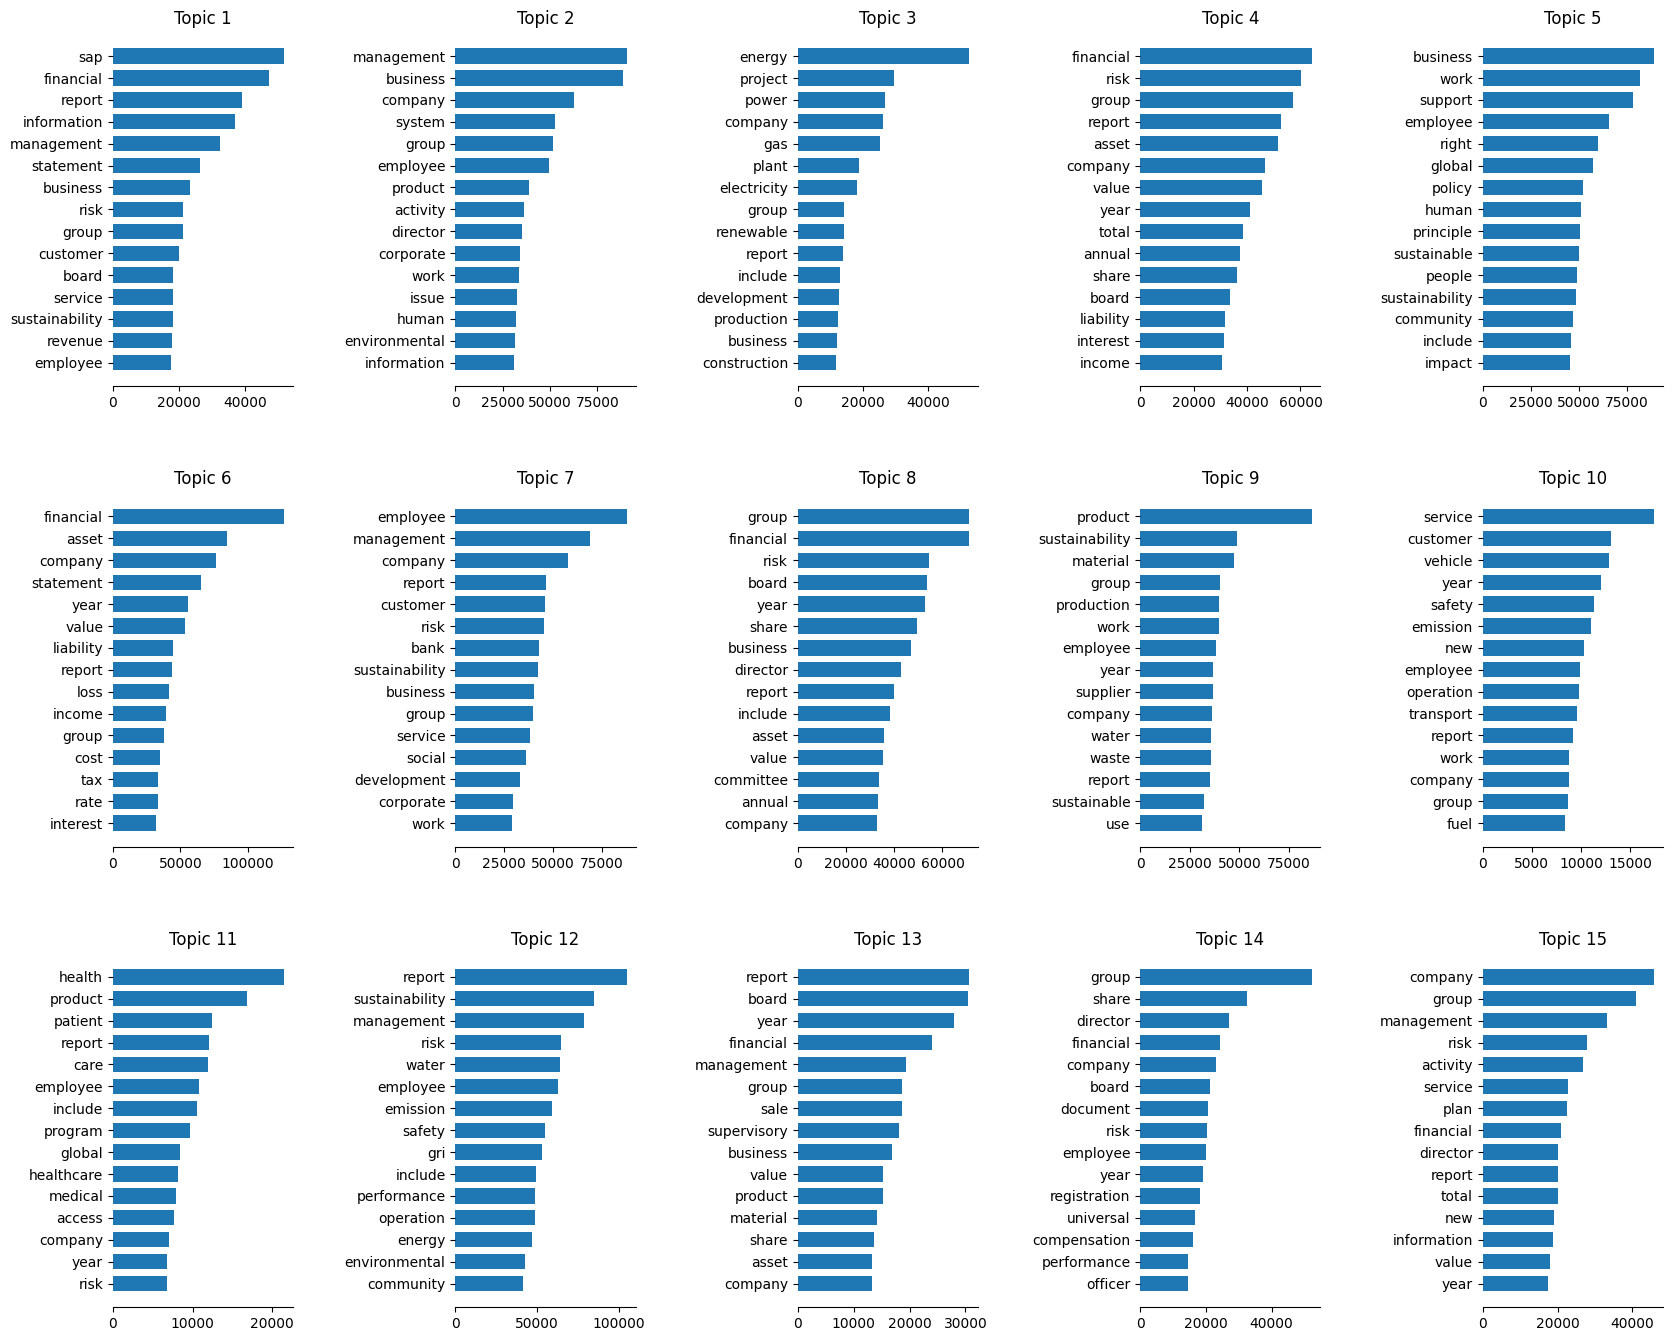

In [29]:
sys.path.append("../code")
from exploration import DataExploration
exploration = DataExploration().load_data()
exploration = exploration.construct_lda(n_topics=15)
exploration.plot_lda_top_words();

## Simple comparison

In [30]:
exploration.data.sector.value_counts().head(10)

sector
Not Applicable                  1045
Diversified                      587
Industrial Support Services      412
Software & Computer Services     333
General Industrials              293
Finance and credit services      266
Food Producers                   195
Chemicals                        177
Construction & Materials         176
Retailers                        158
Name: count, dtype: int64

In [35]:
doc_topic_distribution = pd.DataFrame(exploration.lda_model.transform(exploration.tf_data))
n_topics = doc_topic_distribution.shape[1]
doc_topic_distribution.columns = ["topic_{}".format(i) for i in range(1, n_topics + 1)]
doc_topic_distribution["sector"] = exploration.data.sector
sector_topic_distribution = doc_topic_distribution.groupby("sector", as_index=False).mean()
sector_topic_distribution = sector_topic_distribution\
    .merge(exploration.data.sector.value_counts(), on="sector").rename(columns={"count":"n_docs"})\
    .sort_values("n_docs", ascending=False).reset_index(drop=True)

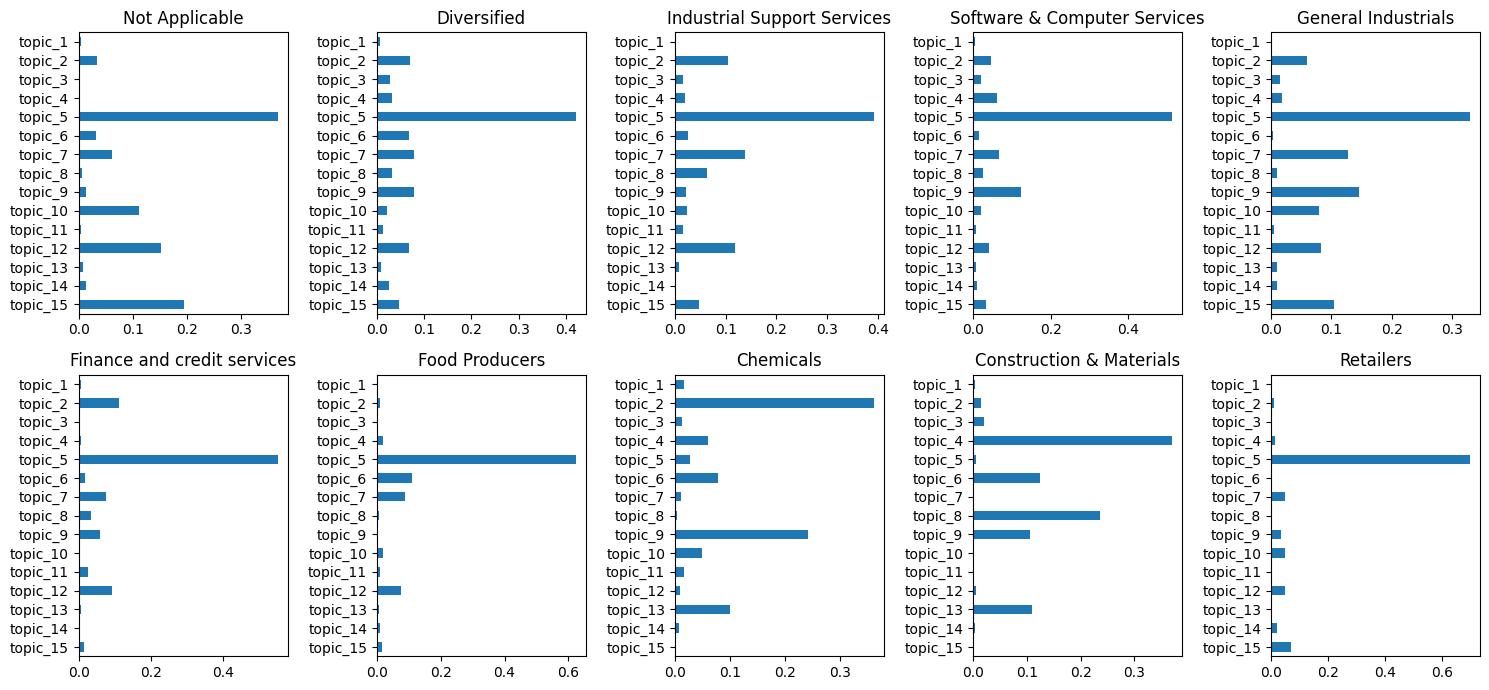

In [36]:
f, axs = plt.subplots(2, 5, figsize=(15, 7))
axs_flat = axs.flatten()
for i, r in sector_topic_distribution\
    .head(10).iterrows():
    sector = r["sector"]
    row_data = r.filter(regex="topic_")
    row_data.plot(kind="barh", ax=axs_flat[i])
    axs_flat[i].invert_yaxis()
    axs_flat[i].set_title(sector)
plt.tight_layout()

## Industry similarity

### Correlation graph

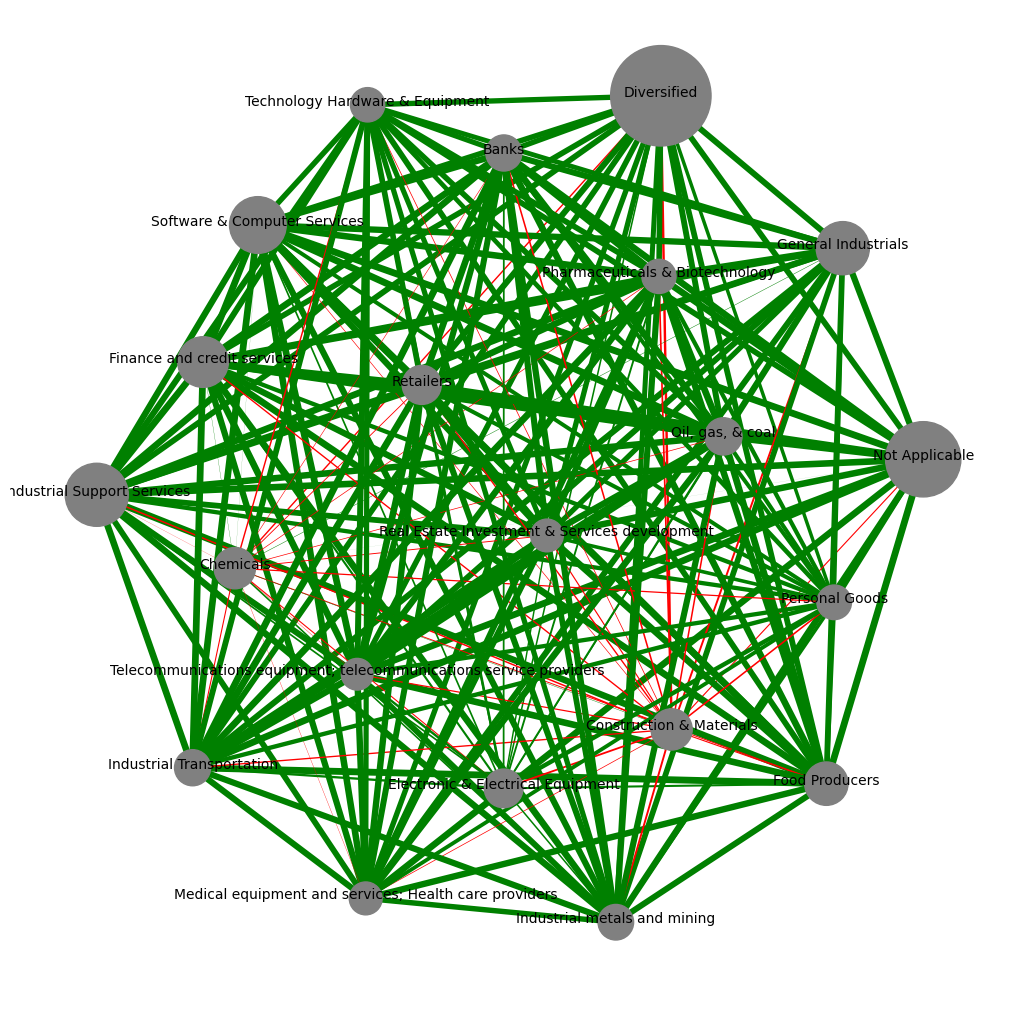

In [127]:
# correlation graph
sector_topic_distribution_filtered = sector_topic_distribution\
    .loc[sector_topic_distribution["n_docs"] > 100, :]

corr_mat = sector_topic_distribution_filtered.filter(regex="topic_").transpose().corr()
edges = pd.melt(corr_mat.reset_index(), id_vars="index").rename(columns={"index":"from", "variable":"to", "value":"correlation"})
edges = edges.loc[edges["from"] > edges["to"]]
edges["correlation"] = edges["correlation"]
nodes = sector_topic_distribution_filtered.loc[:, ["sector", "n_docs"]].rename(columns={"sector":"id"})

G = nx.from_pandas_edgelist(edges, source="from", target="to", edge_attr="correlation")
pos = nx.spring_layout(G, seed=42)
edge_widths = [5 * np.abs(w) for w in edges["correlation"]]
edge_colors = ["red" if w < 0 else "green" for w in edges["correlation"]]
f = plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=nodes["n_docs"] * 5, node_color="gray",
    with_labels=False, font_size=10, width=edge_widths, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, labels=nodes.id, font_size=10, verticalalignment="baseline")
plt.show()

### Hierarchical tree

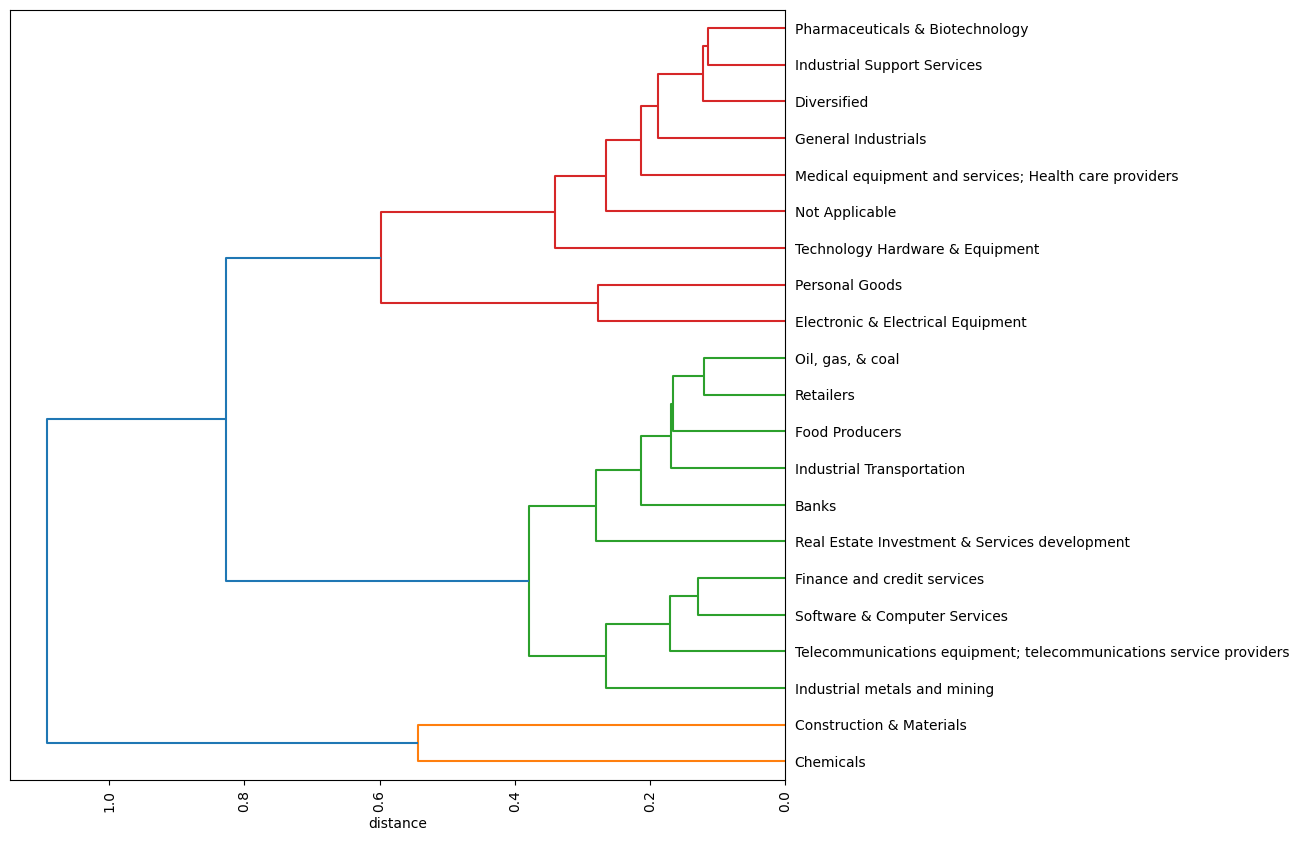

In [128]:
linkage_matrix = linkage(sector_topic_distribution_filtered.filter(regex="topic_"),
    method="ward", metric="euclidean")

f = plt.figure(figsize=(10, 10))
dendrogram(linkage_matrix, labels=sector_topic_distribution_filtered["sector"].tolist(), orientation="left")
plt.xlabel("distance")
plt.xticks(rotation="vertical")
plt.show()

## Document similarity

### Manifold

### Hierarchical tree